In [52]:
#Operaciones matriciales
import numpy as np
#Crear el espacio de aproximación
from skfem import *
from skfem.models.poisson import laplace, mass
#Resolver los sistemas lineales
from scipy.sparse.linalg import spsolve
#Graficar
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# --------------------------
# Proyección de z_d(x, y)
# --------------------------

#Definimos la función objetivo z_d(x, y)

#Solucion manufacturada de y
def y_exact(x, y):
    return x*(1 - x)*y*(1 - y)

def Gety_exact(basis):
    x = basis.doflocs[0, :]  #Coordenadas x
    y = basis.doflocs[1, :]  #Coordenadas y
    return y_exact(x, y) #Evaluacion de y_exact en (x, y)

#Solucion manufacturada de u
def u_exact(x, y):
    return 2*y*(1-y) + 2*x*(1-x)

def Getu_exact(basis):
    x = basis.doflocs[0, :]  #Coordenadas x
    y = basis.doflocs[1, :]  #Coordenadas y
    return u_exact(x, y) #Evaluacion de u_exact en (x, y)

#Solucion manufacturada de p
def p_exact(x, y, beta = 1e-3):
    return -2*beta*y*(1-y) - 2*beta*x*(1-x)

def Getp_exact(basis):
    x = basis.doflocs[0, :]  #Coordenadas x
    y = basis.doflocs[1, :]  #Coordenadas y
    return p_exact(x, y) #Evaluacion de p_exact en (x, y)

def z_d(x, y, beta = 1e-3):
    return x * (1 - x) * y * (1 - y) + 8*beta

#Evaluamos z_d en las coordenadas de los grados de libertad de la base
#Se separan las coordenadas x e y, y luego se evalúa z_d en todos los dofs.
def Getzd(basis):
    x = basis.doflocs[0, :]  #Coordenadas x
    y = basis.doflocs[1, :]  #Coordenadas y
    return z_d(x, y)         #Evaluación de z_d en (x, y)


# --------------------------
# Ecuaciones del sistema
# --------------------------
#y(u) a traves de la ecuacion de estado.
def gety(A, M, u):
    y = spsolve(A, M @ u)
    return y

#p(y) a traves de la ecuacion adjunta.
def getp(A, M, zd, y):
    return spsolve(A, -M @ (y - zd))

#Funcion objetivo J(u, y(u)).
def J(M, beta, zd, y, u):
    return 0.5 * (y - zd).T @ M @ (y - zd) + 0.5 * beta * u.T @ M @ u

#Gradiente de la funcion objetivo
def grad_J(M, beta, u, p):
    return beta * M @ u - M @ p

# --------------------------
# Malla y espacios
# --------------------------

#Generamos el espacio de aproximación
def getSpace(ref):
    #Generamos una malla triangular en el dominio unitario, refinada ref veces.
    mesh = MeshTri().refined(ref)

    #Definimos el espacio de aproximación usando funciones lineales por partes.
    basis = Basis(mesh, ElementTriP1())

    #Ensamblamos la matriz de rigidez.
    A = asm(laplace, basis).tocsc()

    #Ensamblamos la matriz de masa.
    M = asm(mass, basis).tocsc()

    #Obtenemos los grados de libertad.
    N = basis.N

    #print(f"Hay {mesh.p.shape[1]} nodos y {mesh.t.shape[1]} elementos")

    #Aqui guardaremos el ID de los nodos del borde.
    dofs = []

    #Obtenemos las coordenadas de los nodos.
    nodes = basis.doflocs.T

    #Recorremos cada nodo y verifica si está en el borde.
    for i, (x, y) in enumerate(nodes):
        if (abs(x) < 1e-10 or abs(x-1) < 1e-10 or abs(y) < 1e-10 or abs(y-1) < 1e-10):
            dofs.append(i)

    #Lo convertimos a un arreglo de NumPy.
    dofs = np.array(dofs, dtype=int)

    #Dejamos A en formato LIL para poder modificarla.
    A = A.tolil()

    #Imponemos condiciones de Dirichlet homogéneas en el borde.
    for dof in dofs:
        A[:, dof] = 0
        A[dof, dof] = 1

    #Reconvertimos A a formato CSC.
    A = A.tocsc()

    #Retornamos los objetos necesarios
    return basis, A, M, N


# --------------------------
# Método de descenso de gradiente
# --------------------------
#Implementamos el metodo del gradiente
def GradientMethod(beta, sigma=1e-2, rho=0.5, t0=1.0, tmin=1e-20, tol=1e-18, Kmax=200, ref = 7):
    #Obtenemos los elementos necesarios del espacio de aproximacion.
    basis, A, M, N = getSpace(ref)
    
    #Obtenemos la proyeccion de la funcion objetivo sobre el espacio aproximado.
    zd = Getzd(basis)
    
    #Inicializamos el control u de forma aleatoria.
    u = np.random.rand(N)
    #Obtenemos y(u) de la ecuacion de estado.
    y = gety(A, M, u)
    #Obtenemos p(y) de la ecuacion adjunta.
    p = getp(A, M, zd, y)
    #Obtenemos el gradiente de la funcion objetivo.
    grad = grad_J(M, beta, u, p)
    #Obtenemos la norma inicial del gradiente para usarla de referencia.
    norm_grad0 = np.linalg.norm(grad)
    #Obtenemos el valor de la funcion objetivo en el punto inicial.
    J_val = J(M, beta, zd, y, u)
    
    Jv = [J_val]
    gradv = [norm_grad0]
    iters = [0]

    #Inicializamos el contador de iteraciones.
    k = 0
    #Inicializamos el paso del metodo de descenso de gradiente.
    t = t0
    while np.linalg.norm(grad) / norm_grad0 > tol and k < Kmax:
        #Como no reinicializamos el paso, probamos amplificarlo una vez.
        t /= rho
        
        #Intentamos dar un paso usando el valor t actual.
        while t > tmin:
            #Actualizamos de u usando el gradiente y el paso t.
            u_new = u - t * grad
            #Obtenemos y(u) de la ecuacion de estado.
            y_new = gety(A, M, u_new)
            #Obtenemos p(y) de la ecacion adjunta.
            p_new = getp(A, M, zd, y_new)
            #Calculamos el nuevo valor de la funcion objetivo.
            J_new = J(M, beta, zd, y_new, u_new)

            #Verificamos la condicion de Armijo.
            if J_new <= J_val - sigma * t * (grad @ grad):
                #Actualizamos u, y, p, J y su gradiente con los nuevos valores.
                u = u_new
                y = y_new
                p = p_new
                grad = grad_J(M, beta, u, p)
                J_val = J_new
                #Se incrementa el contador de iteraciones.
                k += 1
                Jv.append(J_val)
                gradv.append(np.linalg.norm(grad))
                iters.append(k)
                #Obtenemos informacion relevante para validar que esta funcionando.
                #print(f"Iter {k}: J = {J_val:.6e}, ||grad|| = {np.linalg.norm(grad):.2e}")
                break
            else:
                #Si la condición de Armijo no se cumple, se reduce el paso t y se vuelve a intentar.
                t *= rho
        else:
            #Si no se encuentra un valor adecuado para t, se termina.
            print("Backtracking falló.")
            break
        
    return np.array(Jv), np.array(gradv), np.array(iters)


# --------------------------
# Visualización
# --------------------------

#Creamos una funcion para graficar la solucion
def show(basis, zd, u, y, p):
    
    #Obtenemos las coordenadas de la base
    x = basis.doflocs[0, :]
    y_coords = basis.doflocs[1, :]
    
    #Crear una figura con 4 subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 14))
    
    #Los titulos de cada subplot
    titles = ["Objetivo", "Control", "Estado", "Adjunto"]
    #Y los valores de las funciones
    data = [zd, u, y, p]
    
    #Graficamos cada una de las soluciones
    for i, ax in enumerate(axs.flat):
        #Graficamos la solucion suavizada
        tcf = ax.tricontourf(x, y_coords, data[i], levels=20, cmap='viridis')
        #Configuramos la barra de colores
        fig.colorbar(tcf, ax=ax, format=ScalarFormatter(useOffset=False))
        #Ponemos el titulo y la leyenda de los ejes
        ax.set_title(titles[i])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    
    #Ajustamos los espacios entre subplots.
    plt.tight_layout()
    #Mostramos los graficos
    plt.show()

# --------------------------
# Ejecución modificada
# --------------------------
if __name__ == "__main__":
    
    Jv1, gradv1, iters1 = GradientMethod(1e-3, ref = 6)
    
    print(Jv1, gradv1, iters1)

[0.00033927 0.00033927 0.00033927 0.00033927 0.00033927 0.00033926
 0.00033926 0.00033924 0.00033922 0.00033917 0.00033906 0.00033886
 0.00033845 0.00033764 0.00033605 0.00033295 0.00032712 0.00031676
 0.00030044 0.00028002 0.00026229 0.00024871 0.00024168 0.00024143
 0.00024076 0.00024027 0.00023996 0.00023972 0.00023958 0.00023946
 0.00023939 0.00023933 0.00023929 0.00023926 0.00023925 0.00023923
 0.00023922 0.00023921 0.0002392  0.0002392  0.0002392  0.00023919
 0.00023919 0.00023919 0.00023919 0.00023919 0.00023919 0.00023918
 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918
 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918
 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918
 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918
 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918
 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918
 0.00023918 0.00023918 0.00023918 0.00023918 0.00023918 0.0002

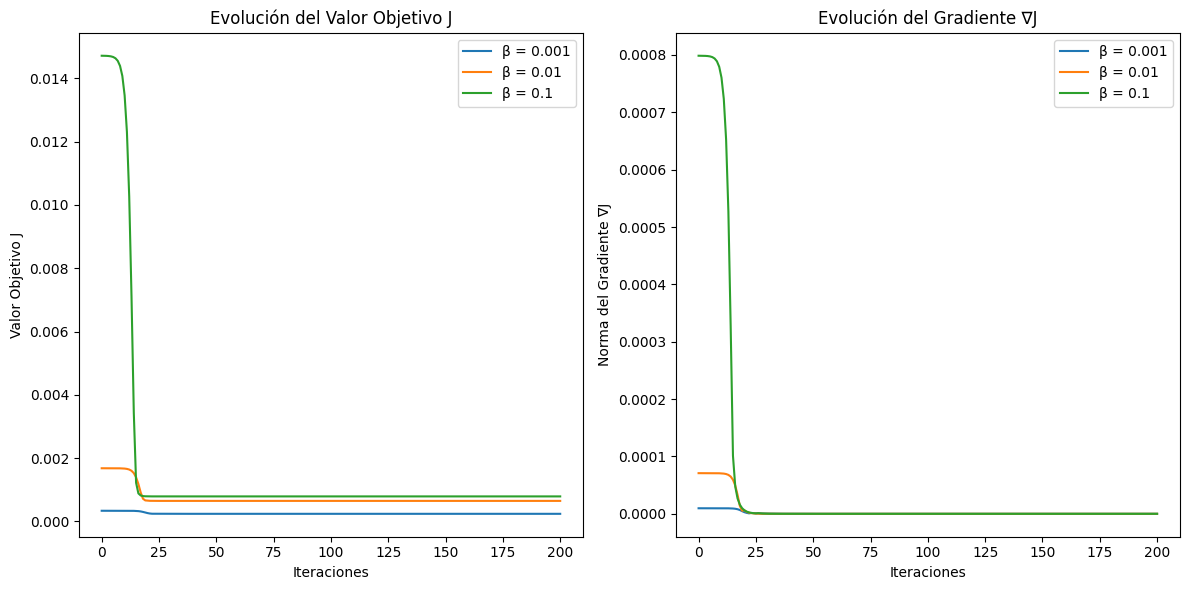

In [55]:
import matplotlib.pyplot as plt

# Definir los valores de beta
betas = [1e-3, 1e-2, 1e-1]

# Crear listas vacías para almacenar los resultados
J_values = []
grad_values = []
iterations = []

# Realizar las simulaciones para los tres valores de beta
for beta in betas:
    Jv, gradv, iters = GradientMethod(beta, ref=6)
    
    J_values.append(Jv)
    grad_values.append(gradv)
    iterations.append(iters)

# Graficar la evolución de J y del gradiente para cada beta
plt.figure(figsize=(12, 6))

# Gráfico del valor objetivo J
plt.subplot(1, 2, 1)
for i, beta in enumerate(betas):
    plt.plot(iterations[i], J_values[i], label=f'β = {beta}')
plt.xlabel('Iteraciones')
plt.ylabel('Valor Objetivo J')
plt.title('Evolución del Valor Objetivo J')
plt.legend()

# Gráfico del gradiente
plt.subplot(1, 2, 2)
for i, beta in enumerate(betas):
    plt.plot(iterations[i], grad_values[i], label=f'β = {beta}')
plt.xlabel('Iteraciones')
plt.ylabel('Norma del Gradiente ∇J')
plt.title('Evolución del Gradiente ∇J')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()
